# **Space X  Falcon 9 First Stage Landing Prediction**


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


## Step 1: Data Collection using SpaceX API
In this step, I collected SpaceX Falcon 9 launch data using the public SpaceX REST API.  
The goal was to extract relevant information such as rocket type, payload mass, orbit, launch site, and landing outcomes.

In [1]:
# Import required libraries
import requests
import pandas as pd
import numpy as np
import datetime

### Retrieve Launch Data from SpaceX API
We begin by sending a GET request to the SpaceX API to obtain data for all past launches.

In [2]:
# Fetch all past launch data
spacex_url = "https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)

# Check status and convert to JSON
print("Response Code:", response.status_code)
data = pd.json_normalize(response.json())
data.head()

Response Code: 200


,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,...,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],Ratsat was carried to orbit on the first succe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=dLQ2tZEH6G0,dLQ2tZEH6G0,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,NaN
4,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,True,[],None,[],[],...,None,None,[],[],http://www.spacex.com/press/2012/12/19/spacexs...,https://www.youtube.com/watch?v=yTaIDooc8Og,yTaIDooc8Og,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,NaN


### Select Relevant Columns
We’ll keep only the columns needed for analysis and prepare them for further extraction using other API endpoints.

In [3]:
# Keep relevant columns
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# Filter out entries with multiple cores or payloads
data = data[data['cores'].map(len) == 1]
data = data[data['payloads'].map(len) == 1]

# Flatten list columns
data['cores'] = data['cores'].map(lambda x: x[0])
data['payloads'] = data['payloads'].map(lambda x: x[0])

# Convert date and filter range
data['date'] = pd.to_datetime(data['date_utc']).dt.date
data = data[data['date'] <= datetime.date(2020, 11, 13)]

### Define Helper Functions for API Calls
Each helper function retrieves additional details using the respective SpaceX API endpoints for rockets, payloads, launchpads, and cores.

In [4]:
# Global lists for extracted data
BoosterVersion, PayloadMass, Orbit, LaunchSite = [], [], [], []
Outcome, Flights, GridFins, Reused, Legs, LandingPad = [], [], [], [], [], []
Block, ReusedCount, Serial, Longitude, Latitude = [], [], [], [], []

# Fetch booster (rocket) name
def getBoosterVersion(data):
    for rocket_id in data['rocket']:
        if rocket_id:
            response = requests.get(f"https://api.spacexdata.com/v4/rockets/{rocket_id}").json()
            BoosterVersion.append(response['name'])

# Fetch launch site name and coordinates
def getLaunchSite(data):
    for site_id in data['launchpad']:
        if site_id:
            response = requests.get(f"https://api.spacexdata.com/v4/launchpads/{site_id}").json()
            Longitude.append(response['longitude'])
            Latitude.append(response['latitude'])
            LaunchSite.append(response['name'])

# Fetch payload mass and orbit
def getPayloadData(data):
    for payload_id in data['payloads']:
        if payload_id:
            response = requests.get(f"https://api.spacexdata.com/v4/payloads/{payload_id}").json()
            PayloadMass.append(response['mass_kg'])
            Orbit.append(response['orbit'])

# Fetch core-related information
def getCoreData(data):
    for core in data['cores']:
        if core['core']:
            response = requests.get(f"https://api.spacexdata.com/v4/cores/{core['core']}").json()
            Block.append(response['block'])
            ReusedCount.append(response['reuse_count'])
            Serial.append(response['serial'])
        else:
            Block.append(None)
            ReusedCount.append(None)
            Serial.append(None)
        Outcome.append(str(core['landing_success']) + " " + str(core['landing_type']))
        Flights.append(core['flight'])
        GridFins.append(core['gridfins'])
        Reused.append(core['reused'])
        Legs.append(core['legs'])
        LandingPad.append(core['landpad'])

### Apply Functions to Extract Detailed Launch Information
We now call the above helper functions to gather all relevant information for each launch record.

In [5]:
getBoosterVersion(data)
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)

### Construct a Clean Combined Dataset
Now we combine all extracted details into a structured DataFrame.

In [6]:
launch_dict = {
    'FlightNumber': list(data['flight_number']),
    'Date': list(data['date']),
    'BoosterVersion': BoosterVersion,
    'PayloadMass': PayloadMass,
    'Orbit': Orbit,
    'LaunchSite': LaunchSite,
    'Outcome': Outcome,
    'Flights': Flights,
    'GridFins': GridFins,
    'Reused': Reused,
    'Legs': Legs,
    'LandingPad': LandingPad,
    'Block': Block,
    'ReusedCount': ReusedCount,
    'Serial': Serial,
    'Longitude': Longitude,
    'Latitude': Latitude
}

newdata = pd.DataFrame(launch_dict)
newdata.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


### Filter for Falcon 9 Launches Only
We’ll now exclude early Falcon 1 launches and keep only Falcon 9 missions for consistency.

In [7]:
# Keep only Falcon 9 launches
data_falcon9 = newdata[newdata['BoosterVersion'] != 'Falcon 1'].reset_index(drop=True)
data_falcon9['FlightNumber'] = range(1, len(data_falcon9) + 1)
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


### Handle Missing Values
The dataset may have missing payload masses. We’ll replace those with the column mean.

In [8]:
data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].fillna(data_falcon9['PayloadMass'].mean())
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [9]:
### Save the Cleaned Dataset
data_falcon9.to_csv('dataset_part_1.csv', index=False)
print("dataset_part_1.csv saved successfully!")

dataset_part_1.csv saved successfully!


## Step 2: Data Collection using Web Scraping
In this step, I collected additional Falcon 9 and Falcon Heavy launch data by scraping a historical Wikipedia page.  
The goal was to extract structured records such as flight number, date, booster version, payload, orbit, and landing outcomes using BeautifulSoup.

In [10]:
# Import required libraries
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

### Define Helper Functions
Helper functions are used to extract clean values from HTML elements, such as date, booster version, payload mass, and landing status.

In [11]:
def date_time(table_cells):
    """Extract date and time from the HTML table cell."""
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """Extract booster version from the HTML table cell."""
    out = ''.join([booster_version for i, booster_version in enumerate(table_cells.strings) if i % 2 == 0][0:-1])
    return out

def landing_status(table_cells):
    """Extract landing status from the HTML table cell."""
    out = [i for i in table_cells.strings][0]
    return out

def get_mass(table_cells):
    """Extract and normalize payload mass (kg) from the HTML table cell."""
    mass = unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass = mass[0:mass.find("kg")+2]
    else:
        new_mass = 0
    return new_mass

def extract_column_from_header(row):
    """Extract column name from the HTML table header cell."""
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
    column_name = ' '.join(row.contents)
    if not(column_name.strip().isdigit()):
        column_name = column_name.strip()
        return column_name

### Access the Wikipedia Page
We’ll scrape a **snapshot** of the official Wikipedia page to ensure data consistency.

In [12]:
# Wikipedia snapshot URL (June 2021)
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/91.0.4472.124 Safari/537.36"
}

# Fetch and parse HTML (with headers)
falconData = requests.get(static_url, headers=headers).text
soup = BeautifulSoup(falconData, "html5lib")

# Verify page title
print(soup.title)

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>


### Extract Column Names
Identify and extract column names from the main Falcon 9 launch table.

In [13]:
html_tables = soup.find_all("table")
first_launch_table = html_tables[2]

column_names = []
for tableHeader in first_launch_table.find_all('th'):
    column = extract_column_from_header(tableHeader)
    if (column and len(column) > 0):
        column_names.append(column)

print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


### Initialize the Launch Records Dictionary
We now create an empty dictionary to store all launch details extracted from the HTML tables.

In [14]:
launch_dict = dict.fromkeys(column_names)
del launch_dict['Date and time ( )']

launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []

# Additional columns
launch_dict['Version Booster'] = []
launch_dict['Booster landing'] = []
launch_dict['Date'] = []
launch_dict['Time'] = []

### Parse and Extract Launch Records
We loop through each launch table row, clean the content, and populate the dictionary.

In [15]:
extracted_row = 0

for table_number, table in enumerate(soup.find_all('table', "wikitable plainrowheaders collapsible")):
    for rows in table.find_all("tr"):
        if rows.th:
            if rows.th.string:
                flight_number = rows.th.string.strip()
                flag = flight_number.isdigit()
        else:
            flag = False
        row = rows.find_all('td')
        if flag:
            extracted_row += 1

            launch_dict['Flight No.'].append(flight_number)
            datatimelist = date_time(row[0])

            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)

            time = datatimelist[1]
            launch_dict['Time'].append(time)

            bv = booster_version(row[1])
            if not(bv):
                bv = row[1].a.string
            launch_dict['Version Booster'].append(bv)

            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site)

            payload = row[3].a.string
            launch_dict['Payload'].append(payload)

            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)

            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit)

            customer = row[6].text.strip()
            launch_dict['Customer'].append(customer)

            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)

            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)

### Create a DataFrame
Convert the parsed launch records into a Pandas DataFrame for easier analysis.

In [16]:
df = pd.DataFrame(launch_dict)
df.head(10)

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.07B0003.18,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,".mw-parser-output .plainlist ol,.mw-parser-out...",Success,F9 v1.07B0004.18,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA (COTS),Success,F9 v1.07B0005.18,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA (CRS),Success\n,F9 v1.07B0006.18,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA (CRS),Success\n,F9 v1.07B0007.18,No attempt\n,1 March 2013,15:10
5,6,VAFB,CASSIOPE,500 kg,Polar orbit,MDA,Success,F9 v1.17B10038,Uncontrolled,29 September 2013,16:00
6,7,CCAFS,SES-8,"3,170 kg",GTO,SES,Success,F9 v1.1,No attempt,3 December 2013,22:41
7,8,CCAFS,Thaicom 6,"3,325 kg",GTO,Thaicom,Success,F9 v1.1,No attempt,6 January 2014,22:06
8,9,Cape Canaveral,SpaceX CRS-3,"2,296 kg",LEO,NASA (CRS),Success\n,F9 v1.1,Controlled,18 April 2014,19:25
9,10,Cape Canaveral,Orbcomm-OG2,"1,316 kg",LEO,Orbcomm,Success,F9 v1.1,Controlled,14 July 2014,15:15


In [17]:
### Save the Scraped Data
df.to_csv('spacex_web_scraped.csv', index=False)
print("Web-scraped data saved as spacex_web_scraped.csv")

Web-scraped data saved as spacex_web_scraped.csv


## Step 3: Data Wrangling
In this step, I performed exploratory data analysis (EDA) to identify patterns and define the target label (`Class`) for supervised learning models.  
The main goal was to determine whether each Falcon 9 launch resulted in a **successful first-stage landing** (`1`) or **unsuccessful landing** (`0`).

In [18]:
# Import required libraries
import pandas as pd
import numpy as np

### Load the Cleaned Dataset
We’ll use the dataset prepared in the previous section.

In [19]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv")
df.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1005,-80.577366,28.561857
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1006,-80.577366,28.561857
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1007,-80.577366,28.561857
8,9,2014-08-05,Falcon 9,4535.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1008,-80.577366,28.561857
9,10,2014-09-07,Falcon 9,4428.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1011,-80.577366,28.561857


### Check Missing Values
Identify missing values in each column as a percentage of total records.

In [20]:
df.isnull().sum() / df.count() * 100

FlightNumber       0.000
Date               0.000
BoosterVersion     0.000
PayloadMass        0.000
Orbit              0.000
LaunchSite         0.000
Outcome            0.000
Flights            0.000
GridFins           0.000
Reused             0.000
Legs               0.000
LandingPad        40.625
Block              0.000
ReusedCount        0.000
Serial             0.000
Longitude          0.000
Latitude           0.000
dtype: float64

### Identify Data Types
Determine which columns are numerical and which are categorical.

In [21]:
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

### Launch Counts by Site
Find how many launches occurred at each SpaceX launch site.

In [22]:
df['LaunchSite'].value_counts()

CCAFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

### Launch Counts by Orbit
Determine the number of launches for each orbit type.

In [23]:
df['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

### Mission Outcomes
Review the number and types of mission outcomes recorded.

In [24]:
landing_outcomes = df['Outcome'].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

Each launch outcome represents a landing attempt result:
- **True Ocean / False Ocean:** landed or failed at ocean location  
- **True RTLS / False RTLS:** landed or failed at ground pad  
- **True ASDS / False ASDS:** landed or failed on drone ship  
- **None ASDS / None None:** failed to land  

Let’s identify outcomes where the landing was unsuccessful.

In [25]:
for i, outcome in enumerate(landing_outcomes.keys()):
    print(i, outcome)

# Define unsuccessful outcomes
bad_outcomes = set(landing_outcomes.keys()[[1, 3, 5, 6, 7]])
bad_outcomes

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

### Create Landing Outcome Label
Create a new binary column `Class` —  
`1` = successful landing, `0` = unsuccessful.

In [26]:
landing_class = []
for outcome in df['Outcome']:
    if outcome in bad_outcomes:
        landing_class.append(0)
    else:
        landing_class.append(1)

df['Class'] = landing_class
df[['Class']].head(8)

,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,1


### View Updated Data
Preview the dataset with the new classification label.

In [27]:
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


### Compute Success Rate
Check the overall percentage of successful first-stage landings.

In [28]:
print(f"Success rate: {round(df['Class'].mean() * 100, 2)}%")

Success rate: 66.67%


In [29]:
### Save the Processed Dataset
df.to_csv("dataset_part_2.csv", index=False)
print("dataset_part_2.csv saved successfully!")

dataset_part_2.csv saved successfully!


## Step 4: SQL Analysis
In this step, I performed SQL-based data exploration and analysis on the SpaceX dataset.  
The goal was to query the data to answer key questions related to launch sites, payloads, booster versions, and mission outcomes.

In [30]:
%load_ext sql
import pandas as pd
import sqlite3

### Connect to SQLite Database
We’ll create a local SQLite database and load the SpaceX dataset into a table.

In [31]:
# Create SQLite connection
con = sqlite3.connect("my_data1.db")
cur = con.cursor()

In [32]:
# Load SpaceX dataset
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")

# Clean column names (replace spaces with underscores)
df.columns = df.columns.str.replace(' ', '_')

# Save dataset into database
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False, method="multi")

print("Data loaded successfully into SPACEXTBL table.")

Data loaded successfully into SPACEXTBL table.


In [33]:
# Remove blank rows from the table
cur.execute("""CREATE TABLE SPACEXTABLE AS 
               SELECT * FROM SPACEXTBL 
               WHERE Date IS NOT NULL;""")
con.commit()

In [34]:
# Load SQL magic extension
%reload_ext sql
%sql sqlite:///my_data1.db

'Connected: @my_data1.db'

### Display Unique Launch Sites

In [35]:
%%sql
SELECT DISTINCT LAUNCH_SITE
FROM SPACEXTBL;

 * sqlite:///my_data1.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


### Display 5 Records Where Launch Sites Begin with "CCA"

In [36]:
%%sql
SELECT *
FROM SPACEXTBL 
WHERE LAUNCH_SITE LIKE "CCA%"
LIMIT 5;

 * sqlite:///my_data1.db
Done.


Date,Time_(UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


### Total Payload Mass for NASA (CRS) Launches

In [37]:
%%sql
SELECT Customer, SUM(PAYLOAD_MASS__KG_) AS Total_NASA_CRS_mass
FROM SPACEXTBL
WHERE Customer = "NASA (CRS)";

 * sqlite:///my_data1.db
Done.


Customer,Total_NASA_CRS_mass
NASA (CRS),45596


### Average Payload Mass for Booster Version F9 v1.1

In [38]:
%%sql
SELECT Booster_Version, AVG(PAYLOAD_MASS__KG_) AS avg_Booster_versionF9_v1_1
FROM SPACEXTBL
WHERE Booster_Version = "F9 v1.1";

 * sqlite:///my_data1.db
Done.


Booster_Version,avg_Booster_versionF9_v1_1
F9 v1.1,2928.4


### First Successful Landing on Ground Pad

In [39]:
%%sql
SELECT Mission_Outcome, MIN(Date) AS Date_First_Succ_Land
FROM SPACEXTBL
WHERE Landing_Outcome = 'Success (ground pad)';

 * sqlite:///my_data1.db
Done.


Mission_Outcome,Date_First_Succ_Land
Success,2015-12-22


### Boosters with Successful Drone Ship Landings and Payload 4000–6000 kg

In [40]:
%%sql
SELECT Booster_Version, Landing_Outcome, PAYLOAD_MASS__KG_
FROM SPACEXTBL
WHERE (PAYLOAD_MASS__KG_ > 4000 AND PAYLOAD_MASS__KG_ < 6000)
      AND Landing_Outcome = 'Success (drone ship)';

 * sqlite:///my_data1.db
Done.


Booster_Version,Landing_Outcome,PAYLOAD_MASS__KG_
F9 FT B1022,Success (drone ship),4696
F9 FT B1026,Success (drone ship),4600
F9 FT B1021.2,Success (drone ship),5300
F9 FT B1031.2,Success (drone ship),5200


### Total Number of Successful and Failed Missions

In [41]:
%%sql
SELECT Mission_Outcome, COUNT(Mission_Outcome) AS "Total (Success or failure)"
FROM SPACEXTBL
GROUP BY Mission_Outcome;

 * sqlite:///my_data1.db
Done.


Mission_Outcome,Total (Success or failure)
Failure (in flight),1
Success,98
Success,1
Success (payload status unclear),1


### Booster Versions Carrying Maximum Payload Mass

In [42]:
%%sql
SELECT Booster_Version, Landing_Outcome, PAYLOAD_MASS__KG_
FROM SPACEXTBL
WHERE PAYLOAD_MASS__KG_ IN (
    SELECT MAX(PAYLOAD_MASS__KG_) 
    FROM SPACEXTBL
);

 * sqlite:///my_data1.db
Done.


Booster_Version,Landing_Outcome,PAYLOAD_MASS__KG_
F9 B5 B1048.4,Success,15600
F9 B5 B1049.4,Success,15600
F9 B5 B1051.3,Success,15600
F9 B5 B1056.4,Failure,15600
F9 B5 B1048.5,Failure,15600
F9 B5 B1051.4,Success,15600
F9 B5 B1049.5,Success,15600
F9 B5 B1060.2,Success,15600
F9 B5 B1058.3,Success,15600
F9 B5 B1051.6,Success,15600


### 2015 Drone Ship Failures — Month, Booster, and Launch Site

In [43]:
%%sql
SELECT Date, Booster_Version, Launch_Site, Landing_Outcome 
FROM SPACEXTBL
WHERE Landing_Outcome = 'Failure (drone ship)' 
  AND Date <= "2015-12-31";

 * sqlite:///my_data1.db
Done.


Date,Booster_Version,Launch_Site,Landing_Outcome
2015-01-10,F9 v1.1 B1012,CCAFS LC-40,Failure (drone ship)
2015-04-14,F9 v1.1 B1015,CCAFS LC-40,Failure (drone ship)


### Rank Landing Outcomes Between 2010–2017

In [44]:
%%sql
SELECT Landing_Outcome, COUNT(Landing_Outcome) AS "Total Count"
FROM SPACEXTBL
WHERE (Landing_Outcome = "Failure (drone ship)" 
       OR Landing_Outcome = "Success (ground pad)")
  AND Date BETWEEN "2010-06-04" AND "2017-03-20"
GROUP BY Landing_Outcome
ORDER BY Landing_Outcome DESC;

 * sqlite:///my_data1.db
Done.


Landing_Outcome,Total Count
Success (ground pad),3
Failure (drone ship),5


**Result:**  
All SQL queries executed successfully, extracting meaningful insights about SpaceX launch sites, booster versions, payloads, and landing outcomes.

## Step 5: Exploratory Data Analysis (EDA) with Data Visualization  
This notebook performs **Exploratory Data Analysis (EDA)** and **Feature Engineering** to understand which factors influence Falcon 9 first-stage landing success.  
We visualize patterns, analyze launch trends, and prepare the dataset for machine learning.

### Objectives
- Perform exploratory data analysis with `pandas`, `matplotlib`, and `seaborn`  
- Engineer numerical and categorical features for model training

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load Dataset

In [46]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


### Flight Number vs Payload Mass vs Launch Outcome

<Figure size 1440x1008 with 0 Axes>

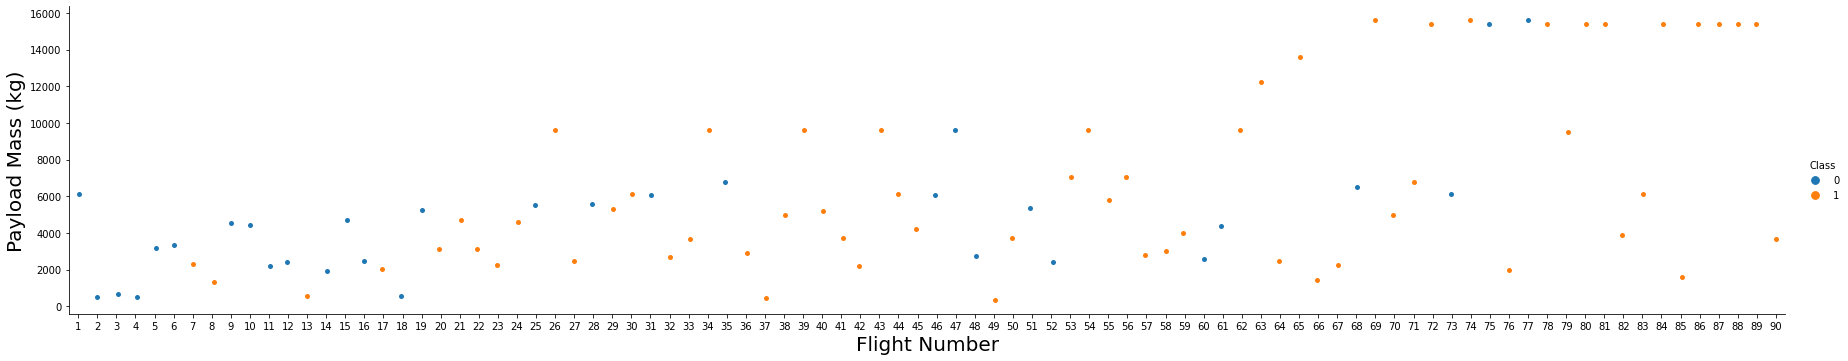

In [47]:
plt.figure(figsize=(20,14))
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect=5)
plt.xlabel("Flight Number", fontsize=20)
plt.ylabel("Payload Mass (kg)", fontsize=20)
plt.show()

### Launch Site vs Flight Number

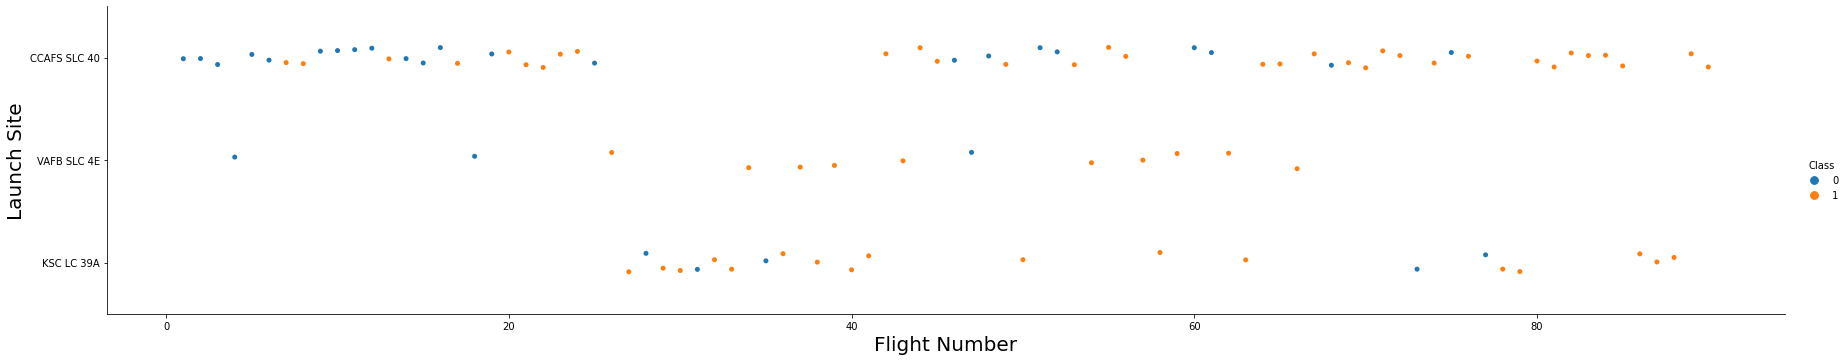

In [48]:
sns.catplot(y='LaunchSite', x='FlightNumber', hue="Class", data=df, aspect=5)
plt.xlabel("Flight Number", fontsize=20)
plt.ylabel("Launch Site", fontsize=20)
plt.show()

### Launch Site vs Payload Mass

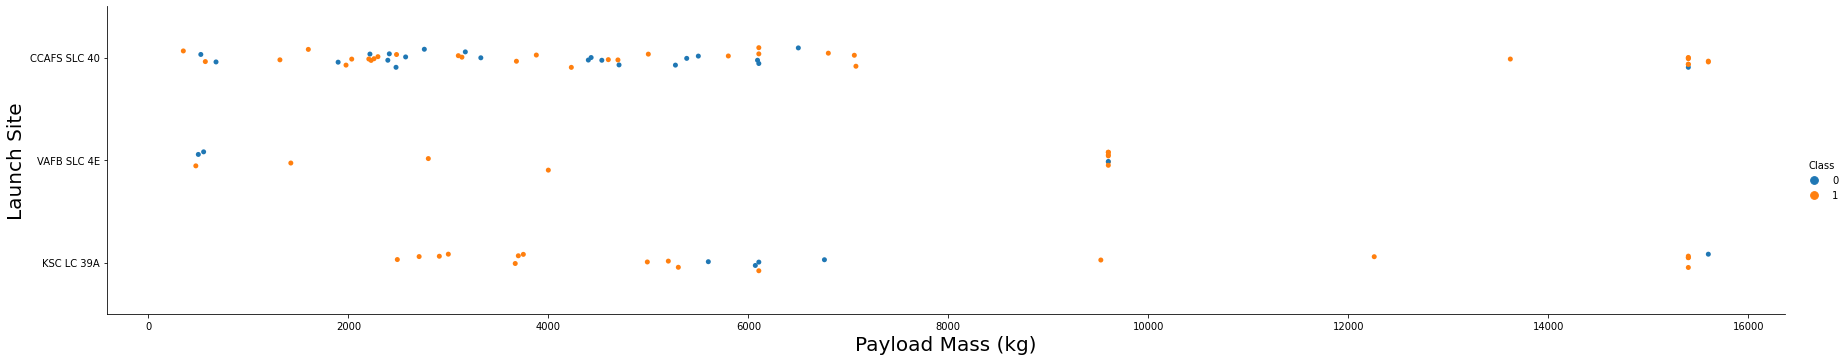

In [49]:
sns.catplot(y="LaunchSite", x="PayloadMass", hue="Class", data=df, aspect=5)
plt.xlabel("Payload Mass (kg)", fontsize=20)
plt.ylabel("Launch Site", fontsize=20)
plt.show()

### Orbit Type vs Success Rate

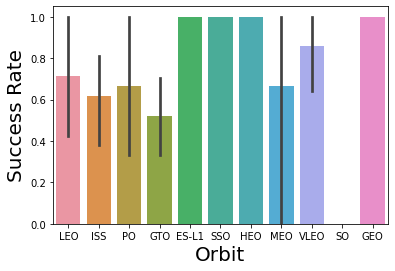

In [50]:
df.groupby(['Orbit'])['Class'].mean()

sns.barplot(x='Orbit', y='Class', data=df)
plt.xlabel('Orbit', fontsize=20)
plt.ylabel("Success Rate", fontsize=20)
plt.show()

### Flight Number vs Orbit Type

<Figure size 1440x1008 with 0 Axes>

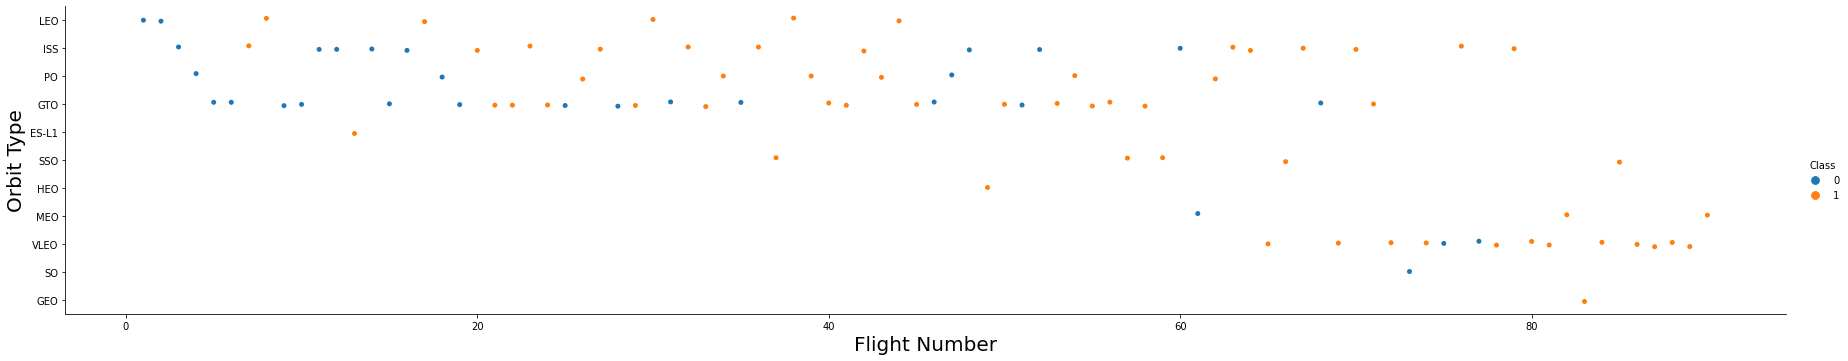

In [51]:
plt.figure(figsize=(20,14))
sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=df, aspect=5)
plt.xlabel("Flight Number", fontsize=20)
plt.ylabel("Orbit Type", fontsize=20)
plt.show()

### Payload vs Orbit Type

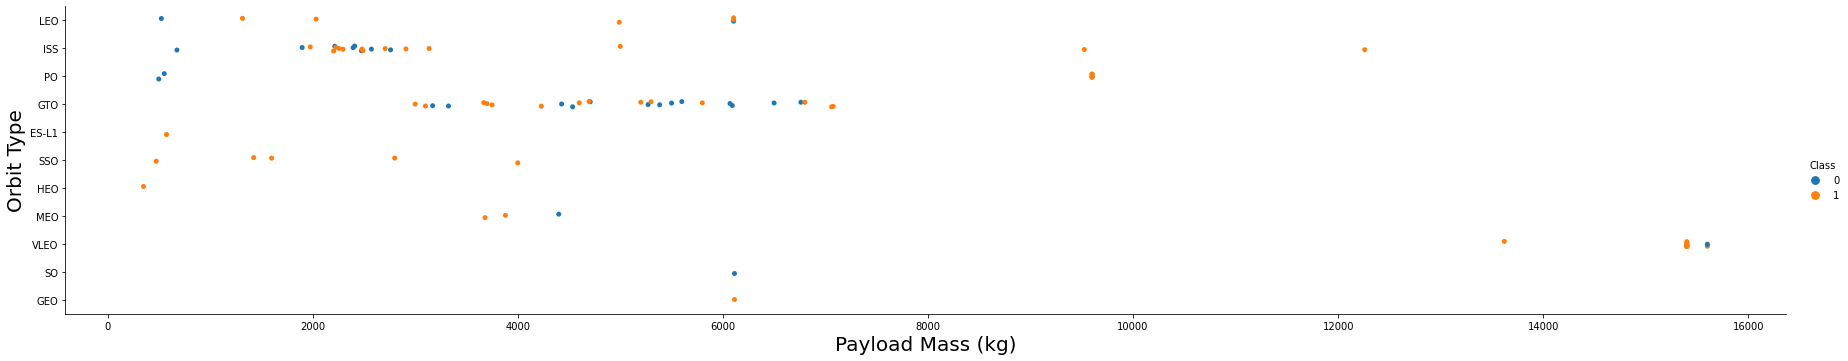

In [52]:
sns.catplot(y="Orbit", x='PayloadMass', hue="Class", data=df, aspect=5)
plt.xlabel("Payload Mass (kg)", fontsize=20)
plt.ylabel("Orbit Type", fontsize=20)
plt.show()

### Launch Success Rate by Year

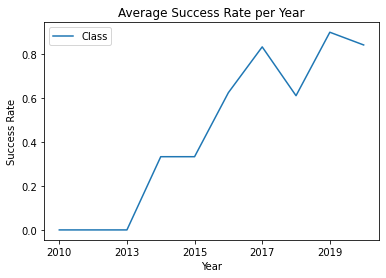

In [53]:
year = []
def Extract_year(date):
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year

df['year'] = Extract_year('')
df[['Class','year']].groupby('year').mean().plot()
plt.title('Average Success Rate per Year')
plt.ylabel('Success Rate')
plt.xlabel('Year')
plt.show()

### Feature Engineering
Select important features for model building.

In [54]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 
               'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 
               'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6104.959412,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


### One-Hot Encoding of Categorical Variables

In [55]:
features_one_hot = pd.get_dummies(features, columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'])

### Convert Numeric Columns to Float64

In [56]:
features_one_hot = features_one_hot.astype(np.float64)
features_one_hot.shape

(90, 80)

In [57]:
### Save Prepared Dataset
features_one_hot.to_csv('dataset_part_3.csv', index=False)
print("dataset_part_3.csv saved successfully.")

dataset_part_3.csv saved successfully.


## Step 6: Launch Sites Location Analysis with Folium

In [58]:
# Import required libraries
import folium
import pandas as pd

# Import useful plugins
from folium.plugins import MarkerCluster, MousePosition
from folium.features import DivIcon

### Load and Preview Dataset
We will use the **`spacex_launch_geo.csv`** dataset which includes launch sites with their latitude, longitude, and success status.

In [59]:
# Read the dataset
spacex_df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')

# Display dataset preview
spacex_df.head()

,Flight Number,Date,Time (UTC),Booster Version,Launch Site,Payload,Payload Mass (kg),Orbit,Customer,Landing Outcome,class,Lat,Long
0,1,2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX,Failure (parachute),0,28.562302,-80.577356
1,2,2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel o...",0.0,LEO (ISS),NASA (COTS) NRO,Failure (parachute),0,28.562302,-80.577356
2,3,2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2+,525.0,LEO (ISS),NASA (COTS),No attempt,0,28.562302,-80.577356
3,4,2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356
4,5,2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356


### Prepare Launch Sites Data
Extract unique launch site names with their corresponding latitude and longitude.

In [60]:
# Select relevant columns
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]

# Extract unique launch sites
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


### Visualize All Launch Sites on Map
We’ll create a Folium map centered at NASA Johnson Space Center, and mark all launch sites using **Circles** and **Labels**.

In [61]:
# Define NASA Johnson Space Center coordinates
nasa_coordinate = [29.559684888503615, -95.0830971930759]

# Initialize map
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)

# Add markers for each launch site
for index, row in launch_sites_df.iterrows():
    folium.Circle(
        [row['Lat'], row['Long']],
        radius=1000,
        color='#d35400',
        fill=True
    ).add_child(folium.Popup(row['Launch Site'])).add_to(site_map)
    
    folium.map.Marker(
        [row['Lat'], row['Long']],
        icon=DivIcon(
            icon_size=(20, 20),
            icon_anchor=(0, 0),
            html=f'<div style="font-size: 12; color:#d35400;"><b>{row["Launch Site"]}</b></div>'
        )
    ).add_to(site_map)

site_map

### Mark Launch Outcomes for Each Site
Enhance the map by color-coding each launch record:
- **Green** = Successful launch (`class=1`)
- **Red** = Failed launch (`class=0`)

In [62]:
# Assign color based on launch outcome
def assign_marker_color(launch_outcome):
    return 'green' if launch_outcome == 1 else 'red'

spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)

# Initialize marker cluster
marker_cluster = MarkerCluster()

# Add markers
for _, row in spacex_df.iterrows():
    folium.Marker(
        [row['Lat'], row['Long']],
        icon=folium.Icon(color=row['marker_color'])
    ).add_to(marker_cluster)

site_map.add_child(marker_cluster)
site_map

### Add Mouse Position Tool
This interactive tool shows the latitude and longitude of any point you hover over on the map.  
We’ll use it to measure distances from launch sites to coastlines, railways, and highways.

In [63]:
# Add Mouse Position plugin
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)
site_map.add_child(mouse_position)
site_map

### Calculate Distances to Nearby Features
We’ll use the **Haversine formula** to compute distance (in km) between two coordinates.

In [64]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6373.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon, dlat = lon2 - lon1, lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

### Example: Distance from CCAFS LC-40 to Coastline

In [65]:
# Coordinates
launch_site_lat, launch_site_lon = 28.563197, -80.576820
coastline_lat, coastline_lon = 28.56334, -80.56799

# Compute distance
distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)
print(f"Distance to Coastline: {distance_coastline:.2f} km")

Distance to Coastline: 0.86 km


In [66]:
# Add marker and line on the map
distance_marker = folium.Marker(
    [coastline_lat, coastline_lon],
    icon=DivIcon(
        icon_size=(20, 20),
        icon_anchor=(0, 0),
        html=f'<div style="font-size: 12; color:#d35400;"><b>{distance_coastline:.2f} KM</b></div>'
    )
)
lines = folium.PolyLine(locations=[[launch_site_lat, launch_site_lon], [coastline_lat, coastline_lon]], weight=1)

site_map.add_child(distance_marker)
site_map.add_child(lines)
site_map

### Visualize Distances to Other Nearby Features
We can repeat the same process for the nearest:
- Highway  
- Railway  
- City  

In [67]:
closest_highway = (28.56335, -80.57085)
closest_railroad = (28.57206, -80.58525)
closest_city = (28.10473, -80.64531)

# Calculate distances
distance_highway = calculate_distance(launch_site_lat, launch_site_lon, *closest_highway)
distance_railroad = calculate_distance(launch_site_lat, launch_site_lon, *closest_railroad)
distance_city = calculate_distance(launch_site_lat, launch_site_lon, *closest_city)

print(f"Distance to Highway: {distance_highway:.2f} km")
print(f"Distance to Railway: {distance_railroad:.2f} km")
print(f"Distance to City: {distance_city:.2f} km")

Distance to Highway: 0.58 km
Distance to Railway: 1.28 km
Distance to City: 51.43 km


In [68]:
# Add markers and connecting lines
for loc, dist in zip(
    [closest_highway, closest_railroad, closest_city],
    [distance_highway, distance_railroad, distance_city]
):
    site_map.add_child(
        folium.Marker(
            loc,
            icon=DivIcon(
                icon_size=(20,20),
                icon_anchor=(0,0),
                html=f'<div style="font-size: 12; color:#d35400;"><b>{dist:.2f} KM</b></div>'
            )
        )
    )
    site_map.add_child(folium.PolyLine(locations=[[launch_site_lat, launch_site_lon], loc], weight=1))

site_map

### Observations
- Most launch sites are **close to coastlines**, minimizing risks in case of launch failure.  
- They are typically **near highways and railways** for logistic convenience.  
- Sites are **far from densely populated cities**, reducing safety hazards.

## Step 7: Interactive Dashboard with Dash

### Objective
In this step, we will build an **interactive dashboard** using **Plotly Dash** to visualize SpaceX Falcon 9 launch records.  
The dashboard will allow users to:
- Select a launch site from a dropdown menu.  
- View a pie chart showing launch success rates.  
- Adjust payload mass range with a slider.  
- See a scatter plot showing the correlation between payload and success.

### Import Libraries
We start by importing all the required libraries for this dashboard.

In [69]:
import pandas as pd
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import plotly.express as px

### Read the Dataset
Load the `spacex_launch_dash.csv` file into a pandas DataFrame.  
We also determine the minimum and maximum payload values for use in the slider.

In [70]:
# Read the SpaceX dataset
spacex_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_dash.csv")

# Get maximum and minimum payload mass
max_payload = spacex_df['Payload Mass (kg)'].max()
min_payload = spacex_df['Payload Mass (kg)'].min()

### Initialize the Dash Application
We will now create a Dash app instance that will serve as the foundation of our dashboard.

In [71]:
# Create a dash application
app = dash.Dash(__name__)

### Define the Application Layout
The layout defines the structure of our web app — including:
- Title  
- Dropdown for launch site selection  
- Pie chart for success rates  
- Slider for payload range  
- Scatter chart for payload vs success relationship

In [72]:
# Create app layout
app.layout = html.Div(children=[
    html.H1('SpaceX Launch Records Dashboard',
            style={'textAlign': 'center', 'color': '#503D36', 'font-size': 40}),
    
    # Dropdown for Launch Site selection
    dcc.Dropdown(id='site-dropdown',
                 options=[{'label': i, 'value': i} for i in spacex_df['Launch Site'].unique()] +
                         [{'label': 'ALL', 'value': 'ALL'}],
                 value='ALL',
                 placeholder='Select a Launch Site here',
                 searchable=True),
    html.Br(),

    # Pie chart for success rate visualization
    html.Div(dcc.Graph(id='success-pie-chart')),
    html.Br(),

    # Payload range slider
    html.P("Payload range (Kg):"),
    dcc.RangeSlider(id='payload-slider',
                    min=0, max=10000, step=1000,
                    value=[min_payload, max_payload]),

    # Scatter chart for correlation analysis
    html.Div(dcc.Graph(id='success-payload-scatter-chart')),
])

### Callback Function for Pie Chart
This callback updates the **pie chart** based on the selected launch site.
- If “ALL” is selected → show total success count for all sites.
- If a single site is selected → show success vs failure count for that site.

In [73]:
# Callback for updating pie chart
@app.callback(
    Output(component_id='success-pie-chart', component_property='figure'),
    Input(component_id='site-dropdown', component_property='value')
)
def create_pie_chart(selected_site):
    if selected_site == 'ALL':
        filtered_df = spacex_df.groupby('Launch Site', as_index=False)['class'].sum()
        fig = px.pie(filtered_df, values='class', names='Launch Site',
                     title='Total Successful Launches by Site')
    else:
        site_df = spacex_df[spacex_df['Launch Site'] == selected_site]
        site_df = site_df['class'].value_counts().reset_index()
        site_df.columns = ['class', 'count']
        fig = px.pie(site_df, values='count', names='class',
                     title=f'Success vs Failure for {selected_site}')
    return fig

### Callback Function for Scatter Plot
This callback updates the **scatter plot** based on:
- Selected launch site  
- Payload range (from slider)  

It shows how payload mass correlates with launch success.

In [74]:
# Callback for updating scatter plot
@app.callback(
    Output(component_id='success-payload-scatter-chart', component_property='figure'),
    [Input(component_id='site-dropdown', component_property='value'),
     Input(component_id='payload-slider', component_property='value')]
)
def create_scatter(selected_site, payload_range):
    low, high = payload_range
    filtered_df = spacex_df[
        (spacex_df['Payload Mass (kg)'] >= low) &
        (spacex_df['Payload Mass (kg)'] <= high)
    ]

    if selected_site == 'ALL':
        fig = px.scatter(filtered_df, x='Payload Mass (kg)', y='class',
                         color='Booster Version Category',
                         title='Correlation between Payload and Success for All Sites')
    else:
        site_df = filtered_df[filtered_df['Launch Site'] == selected_site]
        fig = px.scatter(site_df, x='Payload Mass (kg)', y='class',
                         color='Booster Version Category',
                         title=f'Payload vs Success for site {selected_site}')
    return fig

### Run the Application
Finally, run the Dash server to launch the web dashboard.  

In [75]:
# Run the app
if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)


### Additional Insights and Visualizations
To further explore the SpaceX launch records, the following visualizations highlight key trends and relationships observed in the dataset.  
These charts provide an overview of launch site performance, success rates, payload distribution, and booster reliability — offering a clear summary of the mission outcomes and overall launch success patterns.

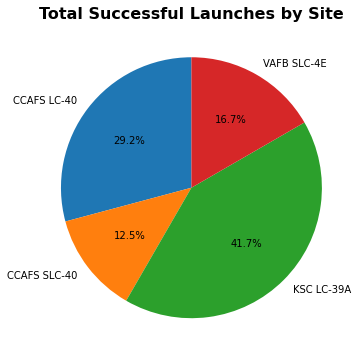

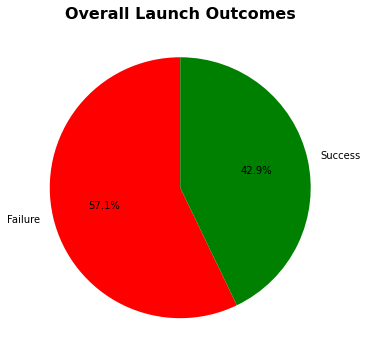

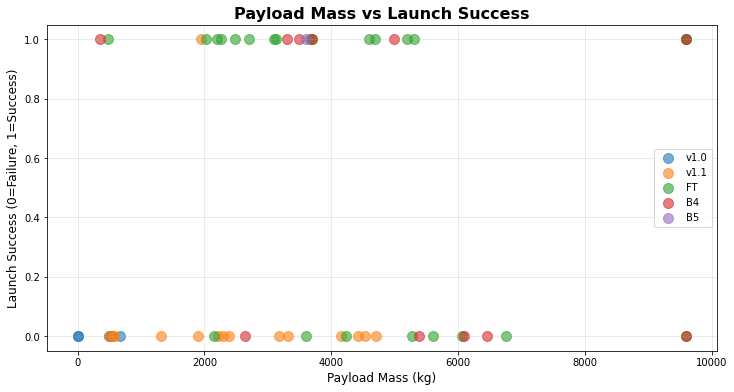

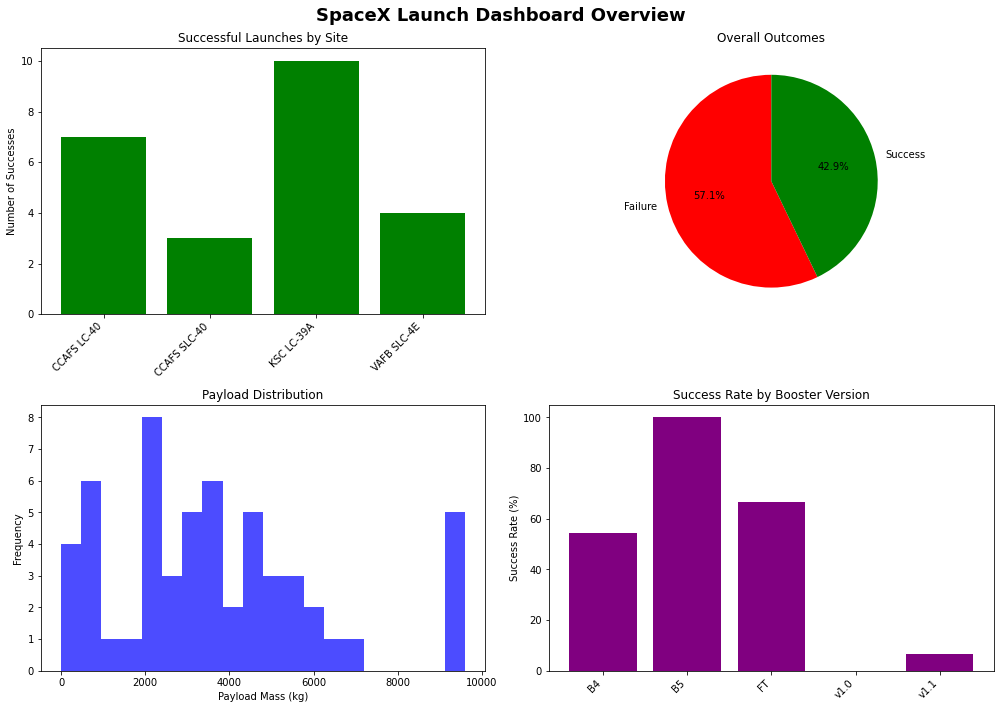

Charts saved: chart1_success_by_site.png, chart2_overall_outcomes.png, chart3_payload_vs_success.png, chart4_dashboard_overview.png


In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Chart 1: Pie chart showing successful launches by site
site_success = spacex_df.groupby('Launch Site')['class'].sum()

plt.figure(figsize=(10, 6))
plt.pie(site_success, labels=site_success.index, autopct='%1.1f%%', startangle=90)
plt.title('Total Successful Launches by Site', fontsize=16, fontweight='bold')
plt.savefig('chart1_success_by_site.png', dpi=300, bbox_inches='tight')
plt.show()

# Chart 2: Pie chart for overall success vs failure
total_success = spacex_df['class'].sum()
total_failure = len(spacex_df) - total_success

plt.figure(figsize=(8, 6))
plt.pie([total_failure, total_success], labels=['Failure', 'Success'], 
        autopct='%1.1f%%', colors=['red', 'green'], startangle=90)
plt.title('Overall Launch Outcomes', fontsize=16, fontweight='bold')
plt.savefig('chart2_overall_outcomes.png', dpi=300, bbox_inches='tight')
plt.show()

# Chart 3: Scatter plot for payload vs success
plt.figure(figsize=(12, 6))

for booster in spacex_df['Booster Version Category'].unique():
    data = spacex_df[spacex_df['Booster Version Category'] == booster]
    plt.scatter(data['Payload Mass (kg)'], data['class'], label=booster, alpha=0.6, s=100)

plt.xlabel('Payload Mass (kg)', fontsize=12)
plt.ylabel('Launch Success (0=Failure, 1=Success)', fontsize=12)
plt.title('Payload Mass vs Launch Success', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('chart3_payload_vs_success.png', dpi=300, bbox_inches='tight')
plt.show()

# Chart 4: Dashboard with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left - bar chart of successful launches
site_stats = spacex_df.groupby('Launch Site')['class'].sum()
axes[0, 0].bar(range(len(site_stats)), site_stats.values, color='green')
axes[0, 0].set_xticks(range(len(site_stats)))
axes[0, 0].set_xticklabels(site_stats.index, rotation=45, ha='right')
axes[0, 0].set_title('Successful Launches by Site')
axes[0, 0].set_ylabel('Number of Successes')

# Top right - pie chart
axes[0, 1].pie([total_failure, total_success], labels=['Failure', 'Success'],
               autopct='%1.1f%%', colors=['red', 'green'], startangle=90)
axes[0, 1].set_title('Overall Outcomes')

# Bottom left - histogram of payload
axes[1, 0].hist(spacex_df['Payload Mass (kg)'], bins=20, color='blue', alpha=0.7)
axes[1, 0].set_xlabel('Payload Mass (kg)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Payload Distribution')

# Bottom right - success rate by booster
booster_stats = spacex_df.groupby('Booster Version Category')['class'].agg(['sum', 'count'])
booster_stats['rate'] = (booster_stats['sum'] / booster_stats['count']) * 100
axes[1, 1].bar(range(len(booster_stats)), booster_stats['rate'], color='purple')
axes[1, 1].set_xticks(range(len(booster_stats)))
axes[1, 1].set_xticklabels(booster_stats.index, rotation=45, ha='right')
axes[1, 1].set_title('Success Rate by Booster Version')
axes[1, 1].set_ylabel('Success Rate (%)')

plt.suptitle('SpaceX Launch Dashboard Overview', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig('chart4_dashboard_overview.png', dpi=300, bbox_inches='tight')
plt.show()

# All charts saved
print("Charts saved: chart1_success_by_site.png, chart2_overall_outcomes.png, chart3_payload_vs_success.png, chart4_dashboard_overview.png")

## Step 8: Predictive Analysis with Machine Learning  

In this step, we build and evaluate multiple machine learning models to predict whether the Falcon 9 first stage will successfully land.  
We use Logistic Regression, Support Vector Machines (SVM), Decision Tree, and K-Nearest Neighbors (KNN) to compare performance based on accuracy and F1-score.

#### Objectives
- Create and preprocess training and test datasets  
- Apply standardization using `StandardScaler`  
- Train models using GridSearchCV for hyperparameter tuning  
- Evaluate model performance (accuracy, precision, recall, F1-score)  
- Identify the best-performing model

In [77]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, precision_score, jaccard_score, 
    accuracy_score, recall_score, confusion_matrix
)

### Define Helper Function
A helper function to visualize the confusion matrix for each model.

In [78]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Did not land', 'Landed'])
    ax.yaxis.set_ticklabels(['Did not land', 'Landed'])
    plt.show()

### Load the Datasets
We load the feature dataset and the target dataset (class labels) prepared in the previous steps.

In [79]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
X = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv")

# Define target variable
Y = data['Class']

### Data Preprocessing
We standardize the feature dataset and split it into training and test sets.

In [80]:
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (72, 83)
Test set size: (18, 83)


### Logistic Regression
We tune the hyperparameters using GridSearchCV and evaluate the model.

In [81]:
parameters = {'C': [0.01, 0.1, 1], 'penalty': ['l2'], 'solver': ['lbfgs']}
lr = LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

print("Best parameters:", logreg_cv.best_params_)
print("Validation Accuracy:", logreg_cv.best_score_)

Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Validation Accuracy: 0.8464285714285713


Accuracy: 0.8333333333333334
Jaccard: 0.8
Precision: 0.8
Recall: 1.0
F1-score: 0.8148148148148149


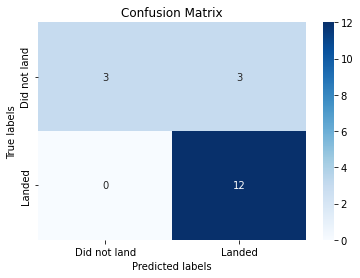

In [82]:
# Evaluate on test data
log_yhat = logreg_cv.predict(X_test)

print("Accuracy:", accuracy_score(Y_test, log_yhat))
print("Jaccard:", jaccard_score(Y_test, log_yhat))
print("Precision:", precision_score(Y_test, log_yhat))
print("Recall:", recall_score(Y_test, log_yhat))
print("F1-score:", f1_score(Y_test, log_yhat, average='weighted'))

plot_confusion_matrix(Y_test, log_yhat)

### Support Vector Machine (SVM)
We perform hyperparameter tuning using GridSearchCV to find the best kernel, C, and gamma values.

In [83]:
parameters = {
    'kernel': ('linear', 'rbf', 'poly', 'sigmoid'),
    'C': np.logspace(-3, 3, 5),
    'gamma': np.logspace(-3, 3, 5)
}

svm = SVC()
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

print("Best parameters:", svm_cv.best_params_)
print("Validation Accuracy:", svm_cv.best_score_)

Best parameters: {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Validation Accuracy: 0.8482142857142856


Accuracy: 0.8333333333333334
Jaccard: 0.8
Precision: 0.8
Recall: 1.0
F1-score: 0.8148148148148149


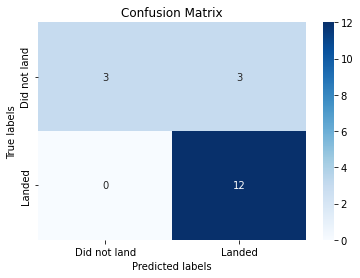

In [84]:
svm_yhat = svm_cv.predict(X_test)

print("Accuracy:", accuracy_score(Y_test, svm_yhat))
print("Jaccard:", jaccard_score(Y_test, svm_yhat))
print("Precision:", precision_score(Y_test, svm_yhat))
print("Recall:", recall_score(Y_test, svm_yhat))
print("F1-score:", f1_score(Y_test, svm_yhat, average='weighted'))

plot_confusion_matrix(Y_test, svm_yhat)

### Decision Tree Classifier
We tune various depth, criterion, and splitting strategy parameters for optimal performance.

In [85]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2 * n for n in range(1, 10)],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

tree = DecisionTreeClassifier(random_state=3)
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)

print("Best parameters:", tree_cv.best_params_)
print("Validation Accuracy:", tree_cv.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
Validation Accuracy: 0.875


Accuracy: 0.9444444444444444
Jaccard: 0.9230769230769231
Precision: 0.9230769230769231
Recall: 1.0
F1-score: 0.9430303030303031


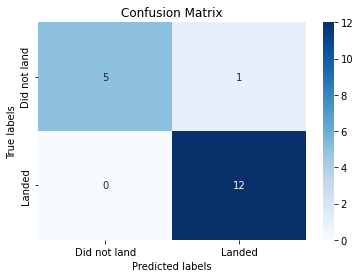

In [86]:
tree_yhat = tree_cv.predict(X_test)

print("Accuracy:", accuracy_score(Y_test, tree_yhat))
print("Jaccard:", jaccard_score(Y_test, tree_yhat))
print("Precision:", precision_score(Y_test, tree_yhat))
print("Recall:", recall_score(Y_test, tree_yhat))
print("F1-score:", f1_score(Y_test, tree_yhat, average='weighted'))

plot_confusion_matrix(Y_test, tree_yhat)

### K-Nearest Neighbors (KNN)
We find the optimal number of neighbors (k) and algorithm type for classification.

In [87]:
parameters = {
    'n_neighbors': range(1, 11),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

print("Best parameters:", knn_cv.best_params_)
print("Validation Accuracy:", knn_cv.best_score_)

Best parameters: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
Validation Accuracy: 0.8482142857142858


Accuracy: 0.8333333333333334
Jaccard: 0.8
Precision: 0.8
Recall: 1.0
F1-score: 0.8148148148148149


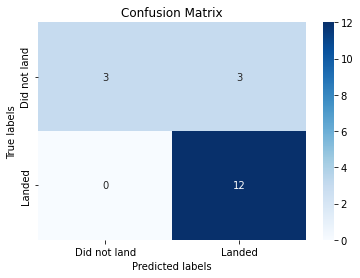

In [88]:
knn_yhat = knn_cv.predict(X_test)

print("Accuracy:", accuracy_score(Y_test, knn_yhat))
print("Jaccard:", jaccard_score(Y_test, knn_yhat))
print("Precision:", precision_score(Y_test, knn_yhat))
print("Recall:", recall_score(Y_test, knn_yhat))
print("F1-score:", f1_score(Y_test, knn_yhat, average='weighted'))

plot_confusion_matrix(Y_test, knn_yhat)

### Model Comparison
We now compare all models using Accuracy and F1-score to identify the best performing algorithm.

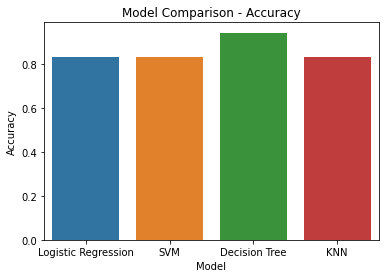

,Model,Accuracy
0,Logistic Regression,0.833333
1,SVM,0.833333
2,Decision Tree,0.944444
3,KNN,0.833333


In [89]:
# Compare accuracy
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Decision Tree', 'KNN'],
    'Accuracy': [
        accuracy_score(Y_test, log_yhat),
        accuracy_score(Y_test, svm_yhat),
        accuracy_score(Y_test, tree_yhat),
        accuracy_score(Y_test, knn_yhat)
    ]
})

sns.barplot(x='Model', y='Accuracy', data=comparison_df)
plt.title('Model Comparison - Accuracy')
plt.show()

comparison_df

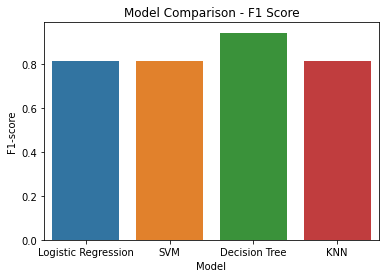

,Model,F1-score
0,Logistic Regression,0.814815
1,SVM,0.814815
2,Decision Tree,0.943030
3,KNN,0.814815


In [90]:
# Compare F1-score
f1_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Decision Tree', 'KNN'],
    'F1-score': [
        f1_score(Y_test, log_yhat, average='weighted'),
        f1_score(Y_test, svm_yhat, average='weighted'),
        f1_score(Y_test, tree_yhat, average='weighted'),
        f1_score(Y_test, knn_yhat, average='weighted')
    ]
})

sns.barplot(x='Model', y='F1-score', data=f1_df)
plt.title('Model Comparison - F1 Score')
plt.show()

f1_df

### Final Observation
Among all models tested, the **Decision Tree Classifier** achieved the highest performance with an accuracy of around **94.4%** and the best F1-score, making it the most effective model for predicting Falcon 9 first-stage landing success.